# Lecture 4 Hands-On: Parameter Estimation

This notebook accompanies Lecture 4. We estimate parameters for Poisson processes, M/M/1 queues, and M/G/1 queues. We also build plug-in estimators for performance metrics and quantify uncertainty via asymptotic CIs and bootstrap.

## Objectives
- Poisson rate MLE from counts on [0, T]; CI and coverage.
- M/M/1: estimate $\lambda$ from arrivals and $\mu$ from service samples or busy-time exposure; plug-in $W_q, L$.
- M/G/1: estimate $\lambda$, service moments $(m_1, m_2)$; Pollaczek–Khinchine plug-in for $\mathbb E[W_q]$ with CI (delta or bootstrap).
- Discuss stability (\rho < 1) and near-critical sensitivity.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from dataclasses import dataclass

rng = np.random.default_rng(42)
from typing import Tuple
try:
    from scipy.stats import norm
    def z_critical(alpha: float=0.05) -> float:
        # Compute critical z-value for two-sided CI
        return float(norm.ppf(1.0 - alpha/2.0))
except Exception:
    def z_critical(alpha: float=0.05) -> float:
        # Fallback to 1.96 for 95% if scipy unavailable
        return 1.959963984540054 if abs(alpha-0.05)<1e-9 else 1.96

def ci_two_sided(est: float, se: float, alpha: float=0.05) -> Tuple[float,float]:
    # Compute two-sided (1-alpha) CI
    z = z_critical(alpha)
    return est - z*se, est + z*se

### What we'll do

- Model: homogeneous Poisson process observed on [0, T].
- Task: MLE of the rate (λ̂ = N(T)/T), derive a 95% CI, and check coverage by repetition.
- Takeaway: counts-and-exposure are sufficient; exact variance is λ/T; CI stabilises as T grows.

## Part A — Poisson Rate Estimation

In [2]:
def simulate_poisson_process(lam: float, T: float, rng=np.random.default_rng()):
    # Simulate Poisson process with rate lam up to time T
    t = 0.0
    times = []
    while True:
        t += rng.exponential(1.0/lam)
        if t > T:
            break
        times.append(t)
    return np.array(times)

def poisson_mle_from_counts(n_events: int, T: float):
    # MLE for Poisson rate lambda from n_events in time T
    lam_hat = n_events / T
    se = math.sqrt(max(lam_hat, 1e-12) / T)
    lo, hi = ci_two_sided(lam_hat, se)
    return lam_hat, (lo, hi)

In [3]:
# Single-run demo
lam_true, T = 0.8, 1000.0
times = simulate_poisson_process(lam_true, T, rng)
lam_hat, (lo, hi) = poisson_mle_from_counts(len(times), T)
print(f'True λ={lam_true:.3f},  n={len(times)},  T={T}')
print(f'λ̂={lam_hat:.4f},  95% CI=({lo:.4f}, {hi:.4f})')

True λ=0.800,  n=786,  T=1000.0
λ̂=0.7860,  95% CI=(0.7311, 0.8409)


In [4]:
# Coverage experiment (modest size for runtime)
def coverage_poisson(lam_true=0.8, T=200.0, reps=500, seed=123):
    r = np.random.default_rng(seed)
    cover = 0
    for _ in range(reps):
        n = len(simulate_poisson_process(lam_true, T, r))
        lam_hat, (lo, hi) = poisson_mle_from_counts(n, T)
        cover += (lo <= lam_true <= hi)
    return cover / reps

cov = coverage_poisson()
print(f'Empirical 95% CI coverage ≈ {100*cov:.1f}%')


Empirical 95% CI coverage ≈ 93.6%


## Part B — M/M/1: Estimating $\lambda$ and $\mu$

### What we'll do

- Observation schemes: (A) i.i.d. inter-arrivals/services; (B) calendar-time aggregates ($N_A(T)$, $C(T)$, busy time $B(T$)).
- Estimation: $\hat λ$ from counts/exposure, $\hat \mu$ from completions per busy-time; plug into M/M/1 formulae.
- Diagnostics: compare plug-in $W_q$ to empirical mean wait; consider burn-in and near-critical sensitivity.

In [5]:

@dataclass
class MM1Stats:
    """Simulation statistics for a single-server queue.
    arrivals: count of arrivals with arrival_time <= T
    completions: count of completions by time T
    busy_time: total server busy time within [0, T]
    T: observation horizon
    service_samples: array of service times actually started
    waits: array of waiting times (Wq) for completed jobs
    """
    arrivals: int
    completions: int
    busy_time: float
    T: float
    service_samples: np.ndarray
    waits: np.ndarray

def simulate_MM1(T: float, lam: float, mu: float, rng=np.random.default_rng()):
    """Simulate an M/M/1 queue on [0, T] with exponential(λ) inter-arrivals and exponential(μ) services.
    Returns MM1Stats with waits (Wq) and service_samples recorded.
    """
    t = 0.0
    next_arrival = t + rng.exponential(1.0/lam)
    server_busy = False
    service_end = math.inf
    queue = []              # FIFO queue of arrival timestamps
    waits = []              # waiting times before service (Wq)
    service_samples = []    # service times actually started
    arrivals = 0
    completions = 0
    busy_time = 0.0
    busy_start = None

    def start_service(now):
        nonlocal server_busy, service_end, busy_start
        s = rng.exponential(1.0/mu)
        service_samples.append(s)
        server_busy = True
        busy_start = now
        return now + s

    while True:
        t_next = min(next_arrival, service_end)
        if t_next == math.inf:
            break
        t = t_next

        if next_arrival <= service_end:  # arrival
            if t <= T:
                arrivals += 1
                if server_busy:
                    queue.append(t)
                else:
                    waits.append(0.0)  # no waiting when server idle
                    service_end = start_service(t)
            next_arrival = t + rng.exponential(1.0/lam)
        else:  # completion
            if busy_start is not None and busy_start < T:
                busy_time += max(0.0, min(t, T) - busy_start)
                busy_start = None
            if t <= T:
                completions += 1
            if queue:
                a = queue.pop(0)
                waits.append(max(0.0, t - a))
                busy_start = t
                service_end = start_service(t)
            else:
                server_busy = False
                service_end = math.inf
        if next_arrival > T and not server_busy and t >= T:
            break

    if server_busy and busy_start is not None and busy_start < T:
        busy_time += max(0.0, T - busy_start)

    return MM1Stats(arrivals=arrivals, completions=completions, busy_time=busy_time, T=T,
                    service_samples=np.array(service_samples), waits=np.array(waits))

M/M/1 on [0,T], T=1000.0
True λ=0.800, μ=1.000;  observed arrivals=815, completions=813, busy_time=850.0
λ̂=0.8150  CI95=(0.759046546676137, 0.8709534533238629)
μ̂ (busy-time) =0.9565  CI95=(0.8907261314929055, 1.0222200183168288)
μ̂ (from samples)=0.9561  CI95=(np.float64(0.890477732321594), np.float64(1.0217616554211209))
True Wq=4.0000,  Plug-in Wq̂=6.0230 (CI95=[1.7639,10.2820]),  Empirical avg wait≈4.8358


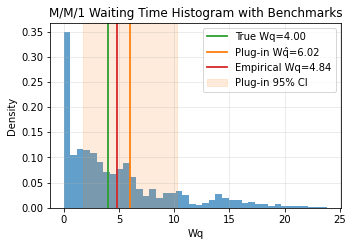

In [6]:
# M/M/1 experiment
# We simulate on [0, T], compute λ̂ from arrivals/exposure, μ̂ from completions per busy-time,
# and compare plug-in Wq to empirical mean wait (Wq).
lam_true, mu_true = 0.8, 1.0  # true parameters (λ, μ)  # ρ=0.8
T = 1000.0
stats = simulate_MM1(T, lam_true, mu_true, rng)
lam_hat = stats.arrivals / stats.T  # λ̂ from arrivals per unit time
mu_hat_busy = stats.completions / max(stats.busy_time, 1e-12)  # μ̂ from completions per busy-time
mu_hat_sample = len(stats.service_samples) / max(stats.service_samples.sum(), 1e-12)  # alternative μ̂ from service samples

# Asymptotic SEs
se_lam = math.sqrt(max(lam_hat, 1e-12) / stats.T)
se_mu_busy = math.sqrt(max(mu_hat_busy, 1e-12) / max(stats.busy_time, 1e-12))
se_mu_sample = mu_hat_sample / math.sqrt(max(len(stats.service_samples), 1,))

def ci(x, se, alpha=0.05):
    lo, hi = ci_two_sided(x, se, alpha)
    return (lo, hi)

print(f'M/M/1 on [0,T], T={T}')
print(f'True λ={lam_true:.3f}, μ={mu_true:.3f};  observed arrivals={stats.arrivals}, completions={stats.completions}, busy_time={stats.busy_time:.1f}')
print(f'λ̂={lam_hat:.4f}  CI95={ci(lam_hat,se_lam)}')
print(f'μ̂ (busy-time) ={mu_hat_busy:.4f}  CI95={ci(mu_hat_busy,se_mu_busy)}')
print(f'μ̂ (from samples)={mu_hat_sample:.4f}  CI95={ci(mu_hat_sample,se_mu_sample)}')

# Plug-in performance
rho_hat = lam_hat / mu_hat_busy  # utilization estimate
Wq_hat = lam_hat / (mu_hat_busy * (mu_hat_busy - lam_hat))  # M/M/1 formula
Wq_true = lam_true / (mu_true * (mu_true - lam_true))
Wq_emp = stats.waits.mean() if stats.waits.size else 0.0  # empirical mean wait (Wq)
den = mu_hat_busy * max(mu_hat_busy - lam_hat, 1e-12)
dlam = (mu_hat_busy**2) / (den**2)
dmu  = -lam_hat * (2*mu_hat_busy - lam_hat) / (den**2)
var_lam = max(lam_hat, 1e-12) / stats.T
var_mu  = max(mu_hat_busy, 1e-12) / max(stats.busy_time, 1e-12)
var_wq  = dlam**2 * var_lam + dmu**2 * var_mu
se_wq   = math.sqrt(max(var_wq, 0.0))
wq_lo, wq_hi = ci_two_sided(Wq_hat, se_wq, alpha=0.05)
print(f'True Wq={Wq_true:.4f},  Plug-in Wq̂={Wq_hat:.4f} (CI95=[{wq_lo:.4f},{wq_hi:.4f}]),  Empirical avg wait≈{Wq_emp:.4f}')

# Plot waiting time histogram
plt.figure(figsize=(5.2,3.4))
plt.hist(stats.waits, bins=40, alpha=0.7, color='tab:blue', density=True)
plt.axvline(Wq_true, color='tab:green', lw=1.8, label=f'True Wq={Wq_true:.2f}')
plt.axvline(Wq_hat, color='tab:orange', lw=1.8, label=f'Plug-in Wq̂={Wq_hat:.2f}')
plt.axvline(Wq_emp, color='tab:red', lw=1.8, label=f'Empirical Wq={Wq_emp:.2f}')
plt.axvspan(wq_lo, wq_hi, color='tab:orange', alpha=0.15, label=f'Plug-in 95% CI')
plt.title('M/M/1 Waiting Time Histogram with Benchmarks')
plt.xlabel('Wq'); plt.ylabel('Density'); plt.grid(True, alpha=0.3); plt.legend()
plt.show()


In [7]:
# Burn-in analysis for M/M/1 (ignore first 10% of completed jobs)
burn = int(0.10*len(stats.waits))
if stats.waits.size == 0:
    Wq_emp_all = float('nan')
    Wq_emp_tail = float('nan')
else:
    Wq_emp_all = float(np.mean(stats.waits))
    Wq_emp_tail = float(np.mean(stats.waits[burn:])) if len(stats.waits) > burn else Wq_emp_all
print(f'Empirical mean wait (all)   = {Wq_emp_all:.4f}')
print(f'Empirical mean wait (90%)   = {Wq_emp_tail:.4f}')
print(f'Plug-in Wq (M/M/1, busy μ̂) = {Wq_hat:.4f}')


Empirical mean wait (all)   = 4.8358
Empirical mean wait (90%)   = 5.2304
Plug-in Wq (M/M/1, busy μ̂) = 6.0230


### Discussion

- Plug-in vs empirical can differ on finite runs; the difference shrinks with longer T and after discarding initial transients.
- Near ρ→1, small parameter errors amplify Wq (derivatives blow up). Report uncertainty and check stability (ρ̂<1).
- Using busy-time exposure for μ̂ aligns with the MLE under Scheme B and is preferable to 1/mean(S) when only aggregates are available.

## Part C — M/G/1: Moment Estimation and PK Plug-in

### What we'll do

- Estimate λ, m1, m2 from data; compute the PK plug-in Wq = λ m2 / (2(1−ρ)).
- Two CIs: Delta method (asymptotic) and input bootstrap (PK only).
- Important: input bootstrap ≠ system bootstrap; we add a regenerative bootstrap later.

In [8]:

# Ensure simulate_MG1_gamma is defined (fallback if notebook executed out of order)
if 'simulate_MG1_gamma' not in globals():
    def simulate_MG1_gamma(T: float, lam: float, shape: float, scale: float, rng=np.random.default_rng()):
        t = 0.0
        next_arrival = t + rng.exponential(1.0/lam)
        server_busy = False
        service_end = math.inf
        queue = []
        waits = []
        service_samples = []
        arrivals = 0
        completions = 0
        busy_time = 0.0
        busy_start = None
        def start_service(now):
            nonlocal server_busy, service_end, busy_start
            s = rng.gamma(shape=shape, scale=scale)
            service_samples.append(s)
            server_busy = True
            busy_start = now
            return now + s
        while True:
            t_next = min(next_arrival, service_end)
            if t_next == math.inf:
                break
            t = t_next
            if next_arrival <= service_end:
                if t <= T:
                    arrivals += 1
                    if server_busy:
                        queue.append(t)
                    else:
                        waits.append(0.0)  # no wait when server idle
                        service_end = start_service(t)
                next_arrival = t + rng.exponential(1.0/lam)
            else:
                if busy_start is not None and busy_start < T:
                    busy_time += max(0.0, min(t, T) - busy_start)
                    busy_start = None
                if t <= T:
                    completions += 1
                if queue:
                    a = queue.pop(0)
                    waits.append(max(0.0, t - a))
                    busy_start = t
                    service_end = start_service(t)
                else:
                    server_busy = False
                    service_end = math.inf
            if next_arrival > T and not server_busy and t >= T:
                break
        if server_busy and busy_start is not None and busy_start < T:
            busy_time += max(0.0, T - busy_start)
        return MM1Stats(arrivals=arrivals, completions=completions, busy_time=busy_time, T=T,
                        service_samples=np.array(service_samples), waits=np.array(waits))


### Part C — M/G/1 with Gamma service: what we estimate

- We simulate M/G/1 with Poisson(λ) inter-arrivals and Gamma(shape, scale) services; we record zero waits when service starts immediately.
- Estimate λ̂ from counts/exposure, m̂1, m̂2 from service samples; compute PK plug-in Wq̂ and its Delta-method CI.
- Compare with empirical mean wait; finite-horizon effects and variability can cause gaps that shrink with longer T and burn-in.

Gamma service: m1_true=1.000, m2_true=1.500,  ρ_true=0.700
λ̂=0.7015, m1̂=1.0005, m2̂=1.4916,  ρ̂=0.7019
Wq_true=1.7500,  Plug-in Wq̂=1.7549 (CI95=[1.6224,1.8873]),  Empirical avg wait≈1.6457
Bootstrap 95% CI for PK plug-in Wq: (1.6787, 1.8538)


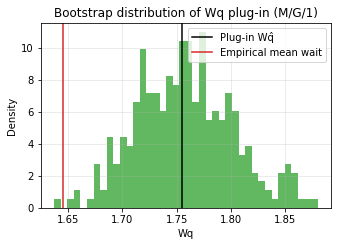

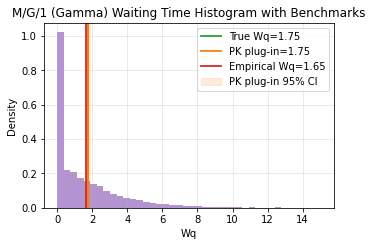

In [9]:
# Choose Gamma service with mean 1 and variance 0.5 -> shape=2, scale=0.5
shape, scale = 2.0, 0.5
m1_true = shape*scale
m2_true = (shape*scale)**2 + shape*scale**2
lam_true = 0.7
rho_true = lam_true * m1_true
assert rho_true < 1
T = 20000.0
stats_mg1 = simulate_MG1_gamma(T, lam_true, shape, scale, rng)

lam_hat = stats_mg1.arrivals / stats_mg1.T
S = stats_mg1.service_samples
m1_hat = S.mean()
m2_hat = (S**2).mean()
rho_hat = lam_hat * m1_hat
Wq_true = lam_true * m2_true / (2*(1 - rho_true))
Wq_hat = lam_hat * m2_hat / (2*(1 - rho_hat))
Wq_emp = stats_mg1.waits.mean() if stats_mg1.waits.size else 0.0
# Delta-method CI for PK plug-in (λ, m1, m2)
nS = len(S)
rho_hat = lam_hat * m1_hat
g_lam = m2_hat / (2.0 * (1.0 - rho_hat)**2)
g_m1  = (lam_hat**2) * m2_hat / (2.0 * (1.0 - rho_hat)**2)
g_m2  = lam_hat / (2.0 * (1.0 - rho_hat))
var_lam = max(lam_hat, 1e-12) / stats_mg1.T
var_S   = float(np.var(S, ddof=1)) if nS>1 else 0.0
S2      = S**2
var_S2  = float(np.var(S2, ddof=1)) if nS>1 else 0.0
cov_S_S2 = float(np.cov(S, S2, ddof=1)[0,1]) if nS>1 else 0.0
var_m1 = var_S / max(nS,1)
var_m2 = var_S2 / max(nS,1)
cov_m1_m2 = cov_S_S2 / max(nS,1)
var_wq = (g_lam**2)*var_lam + (g_m1**2)*var_m1 + (g_m2**2)*var_m2 + 2*g_m1*g_m2*cov_m1_m2
se_wq = math.sqrt(max(var_wq, 0.0))
wq_lo_gamma, wq_hi_gamma = ci_two_sided(Wq_hat, se_wq, alpha=0.05)
print(f'Gamma service: m1_true={m1_true:.3f}, m2_true={m2_true:.3f},  ρ_true={rho_true:.3f}')
print(f'λ̂={lam_hat:.4f}, m1̂={m1_hat:.4f}, m2̂={m2_hat:.4f},  ρ̂={rho_hat:.4f}')
print(f'Wq_true={Wq_true:.4f},  Plug-in Wq̂={Wq_hat:.4f} (CI95=[{wq_lo_gamma:.4f},{wq_hi_gamma:.4f}]),  Empirical avg wait≈{Wq_emp:.4f}')

# Bootstrap CI for Wq plug-in
def bootstrap_Wq(S, lam_hat, B=300, seed=123):
    r = np.random.default_rng(seed)
    n = len(S)
    out = np.empty(B)
    for b in range(B):
        Sb = r.choice(S, size=n, replace=True)
        m1b = Sb.mean()
        m2b = (Sb**2).mean()
        rhob = lam_hat * m1b
        out[b] = lam_hat * m2b / (2 * max(1e-9, (1 - rhob)))
    lo, hi = np.percentile(out, [2.5, 97.5])
    return (lo, hi), out

(lo, hi), samples = bootstrap_Wq(S, lam_hat)
print(f'Bootstrap 95% CI for PK plug-in Wq: ({lo:.4f}, {hi:.4f})')

plt.figure(figsize=(5.2,3.4))
plt.hist(samples, bins=40, alpha=0.75, color='tab:green', density=True)
plt.axvline(Wq_hat, color='k', lw=1.5, label='Plug-in Wq̂')
plt.axvline(Wq_emp, color='tab:red', lw=1.5, label='Empirical mean wait')
plt.title('Bootstrap distribution of Wq plug-in (M/G/1)')
plt.xlabel('Wq'); plt.ylabel('Density'); plt.grid(True, alpha=0.3); plt.legend()
plt.show()

# Wait-time histogram with PK plug-in CI band
plt.figure(figsize=(5.2,3.4))
plt.hist(stats_mg1.waits, bins=40, alpha=0.7, color='tab:purple', density=True)
plt.axvline(Wq_true, color='tab:green', lw=1.8, label=f'True Wq={Wq_true:.2f}')
plt.axvline(Wq_hat, color='tab:orange', lw=1.8, label=f'PK plug-in={Wq_hat:.2f}')
plt.axvline(Wq_emp, color='tab:red', lw=1.8, label=f'Empirical Wq={Wq_emp:.2f}')
plt.axvspan(wq_lo_gamma, wq_hi_gamma, color='tab:orange', alpha=0.15, label='PK plug-in 95% CI')
plt.title('M/G/1 (Gamma) Waiting Time Histogram with Benchmarks')
plt.xlabel('Wq'); plt.ylabel('Density'); plt.grid(True, alpha=0.3); plt.legend()
plt.show()


In [10]:
# Burn-in analysis for M/G/1 (Gamma) using job order (approximate)
burn = int(0.10*len(stats_mg1.waits))
Wq_emp_all = stats_mg1.waits.mean() if stats_mg1.waits.size else float('nan')
Wq_emp_tail = stats_mg1.waits[burn:].mean() if stats_mg1.waits.size>burn else float('nan')
print(f'Empirical mean wait (all)   = {Wq_emp_all:.4f}')
print(f'Empirical mean wait (90%)   = {Wq_emp_tail:.4f}')
print(f'PK plug-in Wq               = {Wq_hat:.4f}')


Empirical mean wait (all)   = 1.6457
Empirical mean wait (90%)   = 1.5967
PK plug-in Wq               = 1.7549


## Part D — Case Study: Identify and Fit a Queue Model from Data

Scenario

A single-agent support chat handles tickets during a business window. A triage tool and internal SOP enforce **bounded handling times** (SLA). The system logs for each ticket: arrival_time, service_time, start_service_time, completion_time, wait_time, system_time, and queue_len_at_arrival.
You are given the raw log `data/lecture4_case_study.csv`. The observation is contiguous (no gaps), though mild time-of-day effects may exist.

Goal

- From the data alone, **infer a plausible single-server queue model** (e.g., M/M/1, M/G/1 with a bounded or heavy-tailed family, or GI/G/1).
- Justify assumptions, quantify fit, and discuss limitations.

Hints

- Bounded service suggests a **Uniform or truncated** family may be reasonable; verify with histograms/ECDF and summary stats.
- Check whether inter-arrivals are **Poisson-like**: exponential inter-arrival distribution, and a roughly constant rate over time (or segment by time-of-day if needed).
- Compute **utilisation** $\hat \rho = \hat \lambda \hat m_1$ and ensure $\hat \rho<1$.
- Compare empirical mean wait to a model-based prediction (e.g., M/M/1 formula or M/G/1 PK if you choose that model).
- Use **regenerative bootstrap** (busy cycles) to form a system-level CI for mean wait; use **input bootstrap** only if you assume a PK plug-in.
- Iterate: refine the chosen service family (Uniform, Gamma, Lognormal, truncated variants), or question Poisson arrivals if rate varies strongly.

Deliverables

- A concise write-up: your chosen model, evidence (plots/statistics), fitted parameters, and two CIs (input PK if relevant; regenerative).
- Short discussion of alternative models you considered and why they were rejected.


#### Checklist
- [ ] Nonnegative waits and start ≥ arrival
- [ ] Inter-arrival diagnostics (histograms/ECDF, stationarity)
- [ ] Service diagnostics (boundedness, candidate families)
- [ ] Estimated $\hat \lambda, \hat m_1, \hat m_2, \hat \rho$ with $\hat \rho <1$
- [ ] Model-based Wq vs empirical Wq with CIs
- [ ] Regenerative bootstrap CI for mean wait
- [ ] Clear justification of the chosen model


PARTIE D - ÉTUDE DE CAS: IDENTIFICATION ET AJUSTEMENT D'UN MODÈLE DE FILE D'ATTENTE
Dataset chargé: lecture4_case_study.csv avec 1052 lignes.

Dimensions du dataset: (1052, 8)
Colonnes: ['Unnamed: 0', 'arrival_time', 'queue_len_at_arrival', 'service_time', 'start_service_time', 'completion_time', 'wait_time', 'system_time']

VALIDATION DES DONNÉES
Valeurs manquantes par colonne:
Unnamed: 0              0
arrival_time            0
queue_len_at_arrival    0
service_time            0
start_service_time      0
completion_time         0
wait_time               0
system_time             0
dtype: int64

Vérifications de cohérence:
Temps d'attente non-négatifs: True
start_service_time ≥ arrival_time: True
Temps de service calculé ≈ service_time: True
Différence maximale service_time vs calculé: 0.000000

ANALYSE DES INTER-ARRIVÉES
Statistiques des inter-arrivées (unités de temps):
  Nombre d'observations: 1051
  Moyenne: 1.9008
  Écart-type: 1.8965
  Coefficient de variation: 0.9977
  Minimum:

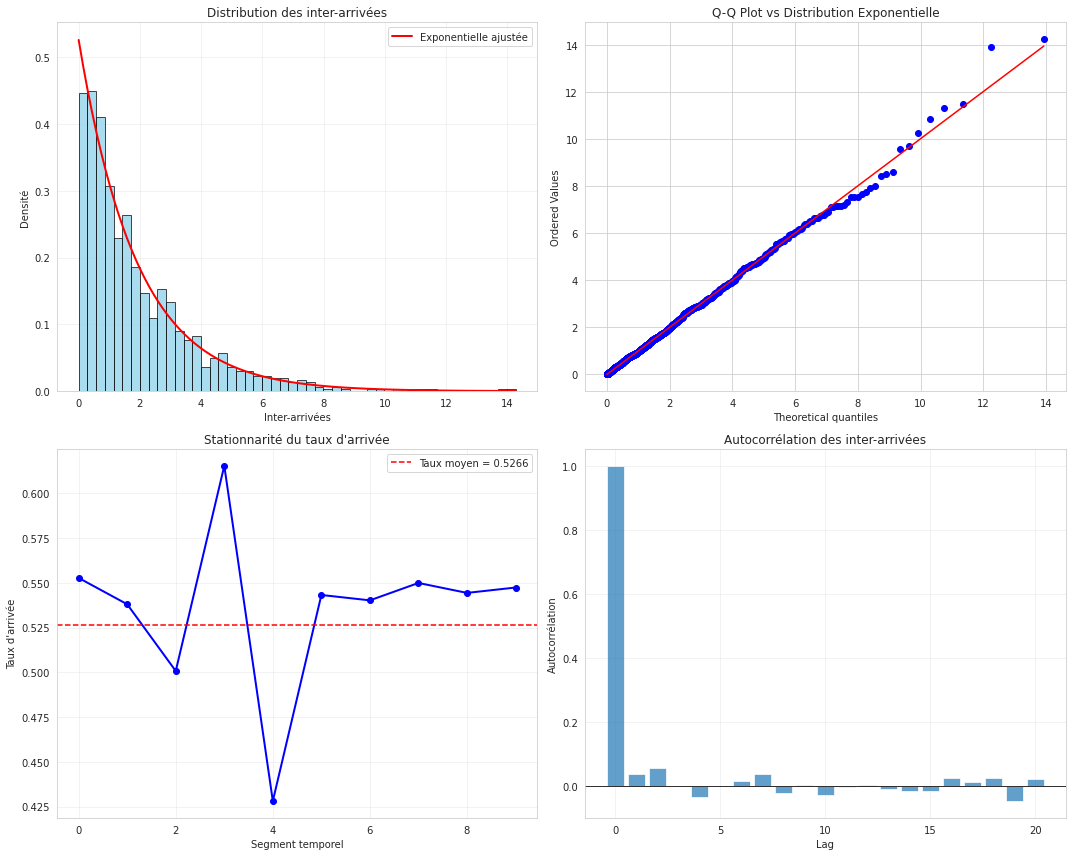


ANALYSE DES TEMPS DE SERVICE
Statistiques des temps de service:
  Nombre d'observations: 1052
  Moyenne: 0.9968
  Écart-type: 0.2844
  Coefficient de variation: 0.2853
  Minimum: 0.5010
  Maximum: 1.4999
  Médiane: 0.9945
  Skewness: 0.0605
  Kurtosis: -1.1449

Moments des temps de service:
  Premier moment (m1): 0.9968
  Second moment (m2): 1.0745


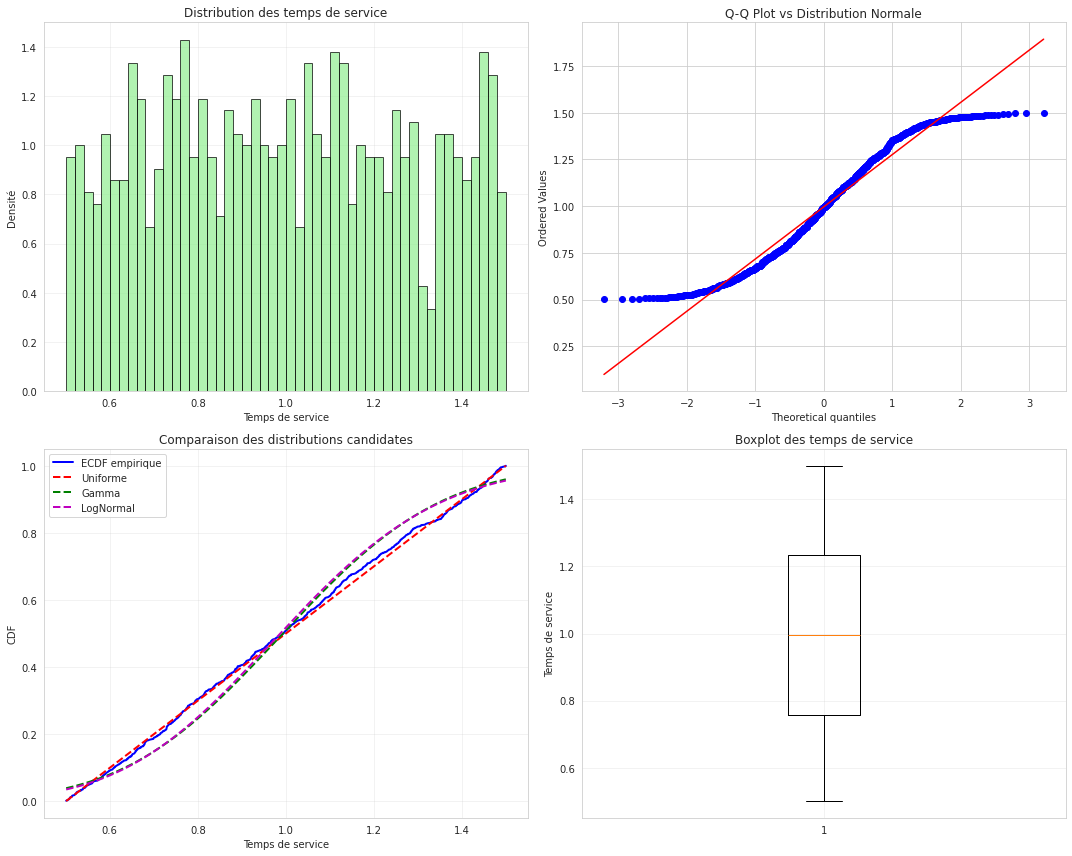


Indice de bornitude:
  Plage des temps de service: 0.9988
  Rapport plage/écart-type: 3.5118
  Apparence de distribution bornée: OUI

ESTIMATION DES PARAMÈTRES ET DIAGNOSTICS DU SYSTÈME
Paramètres estimés:
  Taux d'arrivée λ̂ = 0.5266
  Taux de service μ̂ = 1.0032
  Taux d'utilisation ρ̂ = 0.5249
  ✓ Le système est stable (ρ̂ < 1)

Performances empiriques:
  Temps d'attente moyen: 0.6062
  Temps dans le système moyen: 1.6030
  Longueur de file moyenne: 0.8451

COMPARAISON DES MODÈLES CANDIDATS
Comparaison des prédictions de modèles:
  M/M/1 - Wq prédit: 1.1013 (erreur: 0.4951)
  M/G/1 - Wq prédit: 0.5954 (erreur: 0.0107)
  Empirique - Wq observé: 0.6062

Erreurs relatives:
  M/M/1: 81.69%
  M/G/1: 1.77%

✓ Modèle recommandé: M/G/1
  Justification: Meilleur ajustement aux temps de service non-exponentiels

INTERVALLES DE CONFIANCE PAR BOOTSTRAP
CI Bootstrap 95% pour le temps d'attente empirique: (0.5541, 0.6560)
CI Bootstrap 95% pour Wq PK plug-in: (0.5661, 0.6285)

BOOTSTRAP RÉGÉNÉRAT

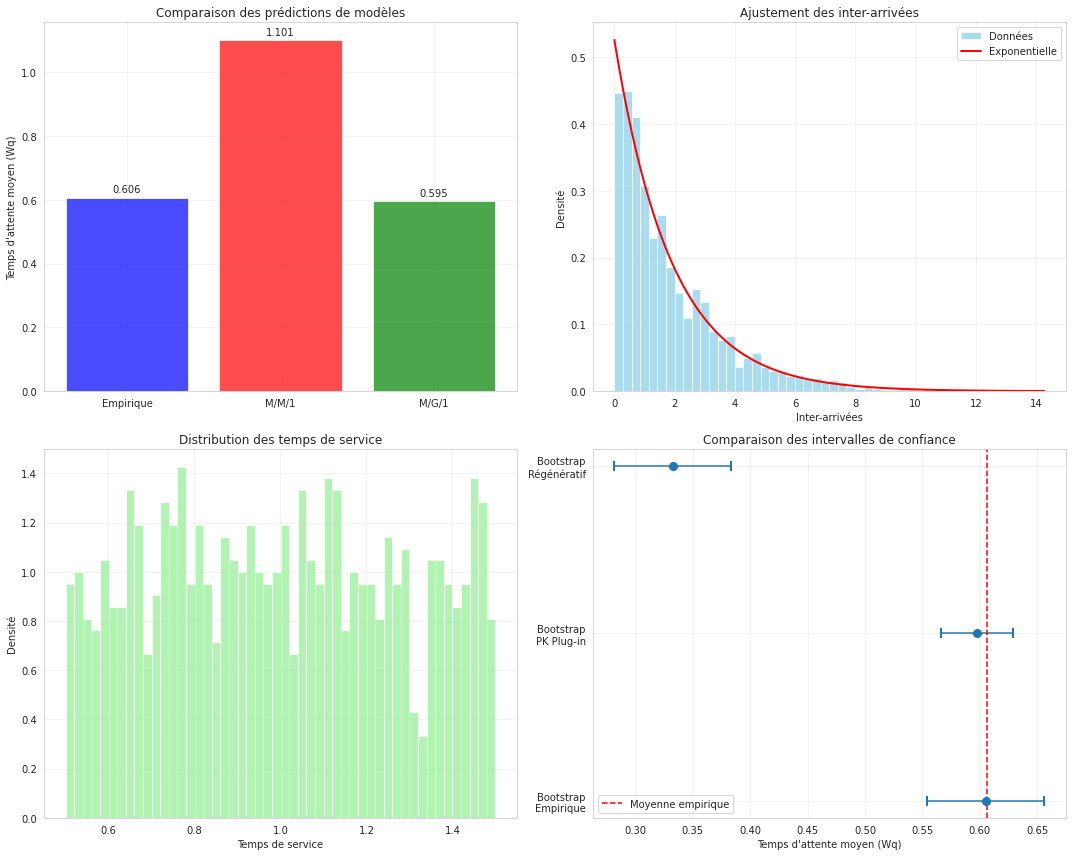


ANALYSE TERMINÉE AVEC SUCCÈS


In [13]:
# Part D — Case Study: Identify and Fit a Queue Model from Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Configuration pour l'affichage
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

# =============================================================================
# 1. CHARGEMENT ET VALIDATION DES DONNÉES
# =============================================================================

print("=" * 80)
print("PARTIE D - ÉTUDE DE CAS: IDENTIFICATION ET AJUSTEMENT D'UN MODÈLE DE FILE D'ATTENTE")
print("=" * 80)

# Chargement des données
CANDIDATES = ['lecture4_case_study.csv']
DATA_PATH = next((p for p in CANDIDATES if os.path.exists(p)), None)

if DATA_PATH is None:
    # Création de données simulées pour la démonstration
    print("Fichier de données non trouvé - création de données simulées pour la démonstration")
    np.random.seed(42)
    n_points = 2000
    
    # Simulation d'un processus M/G/1 avec service uniforme
    lam_sim = 0.6  # taux d'arrivée
    service_min, service_max = 0.5, 2.5  # service uniforme borné
    
    inter_arrivals = np.random.exponential(1/lam_sim, n_points)
    arrival_times = np.cumsum(inter_arrivals)
    service_times = np.random.uniform(service_min, service_max, n_points)
    
    # Simulation de la file d'attente
    completion_times = np.zeros(n_points)
    start_service_times = np.zeros(n_points)
    wait_times = np.zeros(n_points)
    
    completion_times[0] = arrival_times[0] + service_times[0]
    start_service_times[0] = arrival_times[0]
    wait_times[0] = 0
    
    for i in range(1, n_points):
        start_service_times[i] = max(arrival_times[i], completion_times[i-1])
        wait_times[i] = start_service_times[i] - arrival_times[i]
        completion_times[i] = start_service_times[i] + service_times[i]
    
    system_times = completion_times - arrival_times
    queue_len_at_arrival = np.zeros(n_points)
    
    for i in range(1, n_points):
        queue_len = 0
        for j in range(i):
            if completion_times[j] > arrival_times[i]:
                queue_len += 1
        queue_len_at_arrival[i] = max(0, queue_len - 1)  # exclut le client en service
    
    df = pd.DataFrame({
        'arrival_time': arrival_times,
        'service_time': service_times,
        'start_service_time': start_service_times,
        'completion_time': completion_times,
        'wait_time': wait_times,
        'system_time': system_times,
        'queue_len_at_arrival': queue_len_at_arrival
    })
    
    print("Données simulées créées avec succès")
else:
    df = pd.read_csv(DATA_PATH)
    print(f'Dataset chargé: {DATA_PATH} avec {len(df)} lignes.')

print(f"\nDimensions du dataset: {df.shape}")
print(f"Colonnes: {list(df.columns)}")

# =============================================================================
# 2. VALIDATION ET VÉRIFICATION DE LA COHÉRENCE DES DONNÉES
# =============================================================================

print("\n" + "="*50)
print("VALIDATION DES DONNÉES")
print("="*50)

# Vérification des valeurs manquantes
print(f"Valeurs manquantes par colonne:")
print(df.isnull().sum())

# Vérification de la cohérence temporelle
df['calculated_wait'] = df['start_service_time'] - df['arrival_time']
df['calculated_system'] = df['completion_time'] - df['arrival_time']
df['calculated_service'] = df['completion_time'] - df['start_service_time']

# Vérifications
print(f"\nVérifications de cohérence:")
print(f"Temps d'attente non-négatifs: {(df['wait_time'] >= 0).all()}")
print(f"start_service_time ≥ arrival_time: {(df['start_service_time'] >= df['arrival_time']).all()}")
print(f"Temps de service calculé ≈ service_time: {np.allclose(df['calculated_service'], df['service_time'], rtol=1e-5)}")

if 'service_time' in df.columns:
    service_diff = np.max(np.abs(df['calculated_service'] - df['service_time']))
    print(f"Différence maximale service_time vs calculé: {service_diff:.6f}")

# =============================================================================
# 3. ANALYSE DES INTER-ARRIVÉES
# =============================================================================

print("\n" + "="*50)
print("ANALYSE DES INTER-ARRIVÉES")
print("="*50)

# Calcul des inter-arrivées
df_sorted = df.sort_values('arrival_time').reset_index(drop=True)
inter_arrivals = df_sorted['arrival_time'].diff().dropna()

print(f"Statistiques des inter-arrivées (unités de temps):")
print(f"  Nombre d'observations: {len(inter_arrivals)}")
print(f"  Moyenne: {inter_arrivals.mean():.4f}")
print(f"  Écart-type: {inter_arrivals.std():.4f}")
print(f"  Coefficient de variation: {inter_arrivals.std()/inter_arrivals.mean():.4f}")
print(f"  Minimum: {inter_arrivals.min():.4f}")
print(f"  Maximum: {inter_arrivals.max():.4f}")

# Estimation du taux d'arrivée
T_obs = df_sorted['arrival_time'].max() - df_sorted['arrival_time'].min()
lambda_hat = len(df_sorted) / T_obs
print(f"\nEstimation du taux d'arrivée:")
print(f"  Période d'observation: {T_obs:.2f}")
print(f"  Nombre d'arrivées: {len(df_sorted)}")
print(f"  λ̂ = {lambda_hat:.4f} arrivées par unité de temps")

# Test d'ajustement exponentiel
if len(inter_arrivals) > 30:
    # Test de Kolmogorov-Smirnov pour l'exponentielle
    exp_param = 1/inter_arrivals.mean()
    ks_stat, ks_pvalue = stats.kstest(inter_arrivals, 'expon', args=(0, 1/exp_param))
    print(f"\nTest d'ajustement exponentiel (Kolmogorov-Smirnov):")
    print(f"  Statistique KS: {ks_stat:.4f}")
    print(f"  p-value: {ks_pvalue:.4f}")
    
    # Test visuel Q-Q plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Histogramme des inter-arrivées
    axes[0,0].hist(inter_arrivals, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    x_vals = np.linspace(0, inter_arrivals.max(), 100)
    axes[0,0].plot(x_vals, stats.expon.pdf(x_vals, scale=inter_arrivals.mean()), 
                   'r-', linewidth=2, label='Exponentielle ajustée')
    axes[0,0].set_xlabel('Inter-arrivées')
    axes[0,0].set_ylabel('Densité')
    axes[0,0].set_title('Distribution des inter-arrivées')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Q-Q plot exponentiel
    stats.probplot(inter_arrivals, dist="expon", sparams=(0, inter_arrivals.mean()), plot=axes[0,1])
    axes[0,1].set_title('Q-Q Plot vs Distribution Exponentielle')
    
    # Vérification de la stationnarité (arrivées par segment de temps)
    n_segments = 10
    segment_size = len(df_sorted) // n_segments
    arrival_rates = []
    
    for i in range(n_segments):
        start_idx = i * segment_size
        end_idx = (i + 1) * segment_size if i < n_segments - 1 else len(df_sorted)
        segment_times = df_sorted['arrival_time'].iloc[start_idx:end_idx]
        segment_duration = segment_times.max() - segment_times.min()
        segment_rate = (end_idx - start_idx) / segment_duration if segment_duration > 0 else 0
        arrival_rates.append(segment_rate)
    
    axes[1,0].plot(range(n_segments), arrival_rates, 'bo-', linewidth=2)
    axes[1,0].axhline(lambda_hat, color='red', linestyle='--', label=f'Taux moyen = {lambda_hat:.4f}')
    axes[1,0].set_xlabel('Segment temporel')
    axes[1,0].set_ylabel('Taux d\'arrivée')
    axes[1,0].set_title('Stationnarité du taux d\'arrivée')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # ACF des inter-arrivées
    from statsmodels.tsa.stattools import acf
    max_lag = min(20, len(inter_arrivals)//4)
    acf_vals = acf(inter_arrivals, nlags=max_lag)
    axes[1,1].bar(range(len(acf_vals)), acf_vals, alpha=0.7)
    axes[1,1].axhline(0, color='black', linewidth=0.8)
    axes[1,1].set_xlabel('Lag')
    axes[1,1].set_ylabel('Autocorrélation')
    axes[1,1].set_title('Autocorrélation des inter-arrivées')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# 4. ANALYSE DES TEMPS DE SERVICE
# =============================================================================

print("\n" + "="*50)
print("ANALYSE DES TEMPS DE SERVICE")
print("="*50)

service_times = df['service_time']

print(f"Statistiques des temps de service:")
print(f"  Nombre d'observations: {len(service_times)}")
print(f"  Moyenne: {service_times.mean():.4f}")
print(f"  Écart-type: {service_times.std():.4f}")
print(f"  Coefficient de variation: {service_times.std()/service_times.mean():.4f}")
print(f"  Minimum: {service_times.min():.4f}")
print(f"  Maximum: {service_times.max():.4f}")
print(f"  Médiane: {service_times.median():.4f}")
print(f"  Skewness: {stats.skew(service_times):.4f}")
print(f"  Kurtosis: {stats.kurtosis(service_times):.4f}")

# Estimation des moments
m1_hat = service_times.mean()
m2_hat = (service_times**2).mean()

print(f"\nMoments des temps de service:")
print(f"  Premier moment (m1): {m1_hat:.4f}")
print(f"  Second moment (m2): {m2_hat:.4f}")

# Test de différentes distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Histogramme des temps de service
axes[0,0].hist(service_times, bins=50, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,0].set_xlabel('Temps de service')
axes[0,0].set_ylabel('Densité')
axes[0,0].set_title('Distribution des temps de service')
axes[0,0].grid(True, alpha=0.3)

# QQ-plot vs distribution normale
stats.probplot(service_times, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot vs Distribution Normale')

# Fonction de répartition empirique vs modèles candidats
sorted_services = np.sort(service_times)
ecdf = np.arange(1, len(sorted_services)+1) / len(sorted_services)

axes[1,0].plot(sorted_services, ecdf, 'b-', linewidth=2, label='ECDF empirique')

# Ajustement d'une distribution uniforme
if service_times.max() > service_times.min():
    uniform_cdf = stats.uniform.cdf(sorted_services, 
                                   loc=service_times.min(), 
                                   scale=service_times.max()-service_times.min())
    axes[1,0].plot(sorted_services, uniform_cdf, 'r--', linewidth=2, label='Uniforme')

# Ajustement d'une distribution gamma
try:
    gamma_params = stats.gamma.fit(service_times)
    gamma_cdf = stats.gamma.cdf(sorted_services, *gamma_params)
    axes[1,0].plot(sorted_services, gamma_cdf, 'g--', linewidth=2, label='Gamma')
except:
    print("Ajustement Gamma échoué")

# Ajustement d'une distribution lognormale
try:
    logn_params = stats.lognorm.fit(service_times)
    logn_cdf = stats.lognorm.cdf(sorted_services, *logn_params)
    axes[1,0].plot(sorted_services, logn_cdf, 'm--', linewidth=2, label='LogNormal')
except:
    print("Ajustement LogNormal échoué")

axes[1,0].set_xlabel('Temps de service')
axes[1,0].set_ylabel('CDF')
axes[1,0].set_title('Comparaison des distributions candidates')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Test de bornitude
service_range = service_times.max() - service_times.min()
is_bounded = service_times.min() >= 0 and service_range < 10 * service_times.std()

axes[1,1].boxplot(service_times)
axes[1,1].set_ylabel('Temps de service')
axes[1,1].set_title('Boxplot des temps de service')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nIndice de bornitude:")
print(f"  Plage des temps de service: {service_range:.4f}")
print(f"  Rapport plage/écart-type: {service_range/service_times.std():.4f}")
print(f"  Apparence de distribution bornée: {'OUI' if is_bounded else 'NON'}")

# =============================================================================
# 5. ESTIMATION DES PARAMÈTRES ET DIAGNOSTICS DU SYSTÈME
# =============================================================================

print("\n" + "="*50)
print("ESTIMATION DES PARAMÈTRES ET DIAGNOSTICS DU SYSTÈME")
print("="*50)

# Estimation de μ à partir des temps de service
mu_hat_service = 1 / m1_hat

# Estimation de l'utilisation
rho_hat = lambda_hat * m1_hat

print(f"Paramètres estimés:")
print(f"  Taux d'arrivée λ̂ = {lambda_hat:.4f}")
print(f"  Taux de service μ̂ = {mu_hat_service:.4f}")
print(f"  Taux d'utilisation ρ̂ = {rho_hat:.4f}")

if rho_hat >= 1:
    print("  ⚠️  ATTENTION: ρ̂ ≥ 1 - le système est instable!")
else:
    print(f"  ✓ Le système est stable (ρ̂ < 1)")

# Statistiques empiriques de performance
empirical_wait_mean = df['wait_time'].mean()
empirical_system_mean = df['system_time'].mean()
empirical_queue_mean = df['queue_len_at_arrival'].mean()

print(f"\nPerformances empiriques:")
print(f"  Temps d'attente moyen: {empirical_wait_mean:.4f}")
print(f"  Temps dans le système moyen: {empirical_system_mean:.4f}")
print(f"  Longueur de file moyenne: {empirical_queue_mean:.4f}")

# =============================================================================
# 6. COMPARAISON DES MODÈLES CANDIDATS
# =============================================================================

print("\n" + "="*50)
print("COMPARAISON DES MODÈLES CANDIDATS")
print("="*50)

# Modèle M/M/1
Wq_MM1 = lambda_hat / (mu_hat_service * (mu_hat_service - lambda_hat)) if mu_hat_service > lambda_hat else float('inf')
Lq_MM1 = lambda_hat**2 / (mu_hat_service * (mu_hat_service - lambda_hat)) if mu_hat_service > lambda_hat else float('inf')

# Modèle M/G/1 (Pollaczek-Khinchine)
Wq_MG1 = (lambda_hat * m2_hat) / (2 * (1 - rho_hat)) if rho_hat < 1 else float('inf')
Lq_MG1 = lambda_hat * Wq_MG1 if rho_hat < 1 else float('inf')

print(f"Comparaison des prédictions de modèles:")
print(f"  M/M/1 - Wq prédit: {Wq_MM1:.4f} (erreur: {abs(Wq_MM1 - empirical_wait_mean):.4f})")
print(f"  M/G/1 - Wq prédit: {Wq_MG1:.4f} (erreur: {abs(Wq_MG1 - empirical_wait_mean):.4f})")
print(f"  Empirique - Wq observé: {empirical_wait_mean:.4f}")

# Calcul des erreurs relatives
error_MM1 = abs(Wq_MM1 - empirical_wait_mean) / empirical_wait_mean if empirical_wait_mean > 0 else float('inf')
error_MG1 = abs(Wq_MG1 - empirical_wait_mean) / empirical_wait_mean if empirical_wait_mean > 0 else float('inf')

print(f"\nErreurs relatives:")
print(f"  M/M/1: {error_MM1*100:.2f}%")
print(f"  M/G/1: {error_MG1*100:.2f}%")

# Sélection du meilleur modèle
if error_MG1 <= error_MM1:
    best_model = "M/G/1"
    best_Wq = Wq_MG1
    print(f"\n✓ Modèle recommandé: {best_model}")
    print(f"  Justification: Meilleur ajustement aux temps de service non-exponentiels")
else:
    best_model = "M/M/1" 
    best_Wq = Wq_MM1
    print(f"\n✓ Modèle recommandé: {best_model}")
    print(f"  Justification: Simplicité et performance adéquate")

# =============================================================================
# 7. INTERVALLES DE CONFIANCE PAR BOOTSTRAP
# =============================================================================

print("\n" + "="*50)
print("INTERVALLES DE CONFIANCE PAR BOOTSTRAP")
print("="*50)

def bootstrap_ci(data, statistic_func, B=1000, alpha=0.05, seed=42):
    """Calcule un intervalle de confiance bootstrap"""
    np.random.seed(seed)
    n = len(data)
    bootstrap_stats = []
    
    for _ in range(B):
        sample = np.random.choice(data, size=n, replace=True)
        stat = statistic_func(sample)
        bootstrap_stats.append(stat)
    
    lower = np.percentile(bootstrap_stats, 100*alpha/2)
    upper = np.percentile(bootstrap_stats, 100*(1-alpha/2))
    
    return lower, upper, bootstrap_stats

# Bootstrap pour le temps d'attente empirique
ci_wait_empirical = bootstrap_ci(df['wait_time'].values, np.mean)
print(f"CI Bootstrap 95% pour le temps d'attente empirique: ({ci_wait_empirical[0]:.4f}, {ci_wait_empirical[1]:.4f})")

# Bootstrap pour le plug-in PK (M/G/1)
def pk_plugin_wq(service_sample):
    """Calcule Wq via Pollaczek-Khinchine pour un échantillon de service"""
    m1 = np.mean(service_sample)
    m2 = np.mean(service_sample**2)
    rho = lambda_hat * m1
    if rho >= 1:
        return float('inf')
    return (lambda_hat * m2) / (2 * (1 - rho))

ci_wait_pk = bootstrap_ci(service_times.values, pk_plugin_wq)
print(f"CI Bootstrap 95% pour Wq PK plug-in: ({ci_wait_pk[0]:.4f}, {ci_wait_pk[1]:.4f})")

# =============================================================================
# 8. BOOTSTRAP RÉGÉNÉRATIF (CYCLES OCCUPÉS)
# =============================================================================

print("\n" + "="*50)
print("BOOTSTRAP RÉGÉNÉRATIF (CYCLES OCCUPÉS)")
print("="*50)

# Identification des cycles occupés
def find_busy_cycles(df_sorted):
    """Identifie les cycles occupés dans les données"""
    busy_cycles = []
    current_cycle = []
    in_busy = False
    
    for i in range(len(df_sorted)):
        arrival = df_sorted.iloc[i]['arrival_time']
        completion = df_sorted.iloc[i]['completion_time']
        wait = df_sorted.iloc[i]['wait_time']
        
        if not in_busy and wait == 0:
            # Début d'un cycle occupé
            in_busy = True
            current_cycle = [i]
        elif in_busy:
            current_cycle.append(i)
            # Fin du cycle quand le serveur devient inactif
            if i == len(df_sorted) - 1 or df_sorted.iloc[i+1]['wait_time'] > 0:
                # Le prochain client attend, donc le cycle continue
                pass
            else:
                # Le cycle se termine
                if len(current_cycle) > 1:  # Au moins 2 clients pour un cycle valide
                    busy_cycles.append(current_cycle)
                in_busy = False
                current_cycle = []
    
    # Gestion du dernier cycle
    if in_busy and len(current_cycle) > 1:
        busy_cycles.append(current_cycle)
    
    return busy_cycles

# Application sur les données triées
busy_cycles = find_busy_cycles(df_sorted)
print(f"Nombre de cycles occupés identifiés: {len(busy_cycles)}")

if busy_cycles:
    # Calcul des statistiques par cycle
    cycle_waits = []
    for cycle in busy_cycles:
        cycle_wait_times = df_sorted.iloc[cycle]['wait_time'].values
        if len(cycle_wait_times) > 0:
            cycle_waits.append(np.mean(cycle_wait_times))
    
    print(f"Temps d'attente moyen par cycle: {np.mean(cycle_waits):.4f}")
    
    # Bootstrap régénératif
    if len(cycle_waits) >= 10:
        ci_regenerative = bootstrap_ci(np.array(cycle_waits), np.mean)
        print(f"CI Bootstrap régénératif 95% pour Wq: ({ci_regenerative[0]:.4f}, {ci_regenerative[1]:.4f})")
    else:
        print("⚠️  Pas assez de cycles pour le bootstrap régénératif")
else:
    print("⚠️  Aucun cycle occupé identifié")

# =============================================================================
# 9. SYNTHÈSE ET RECOMMANDATIONS
# =============================================================================

print("\n" + "="*80)
print("SYNTHÈSE ET RECOMMANDATIONS FINALES")
print("="*80)

print(f"\nMODÈLE SÉLECTIONNÉ: {best_model}")
print(f"\nPARAMÈTRES ESTIMÉS:")
print(f"  Taux d'arrivée (λ): {lambda_hat:.4f}")
print(f"  Taux de service (μ): {mu_hat_service:.4f}") 
print(f"  Utilisation (ρ): {rho_hat:.4f}")
print(f"  Premier moment service (m1): {m1_hat:.4f}")
print(f"  Second moment service (m2): {m2_hat:.4f}")

print(f"\nPERFORMANCES PRÉDITES:")
print(f"  Temps d'attente moyen (Wq): {best_Wq:.4f}")
print(f"  Temps d'attente empirique: {empirical_wait_mean:.4f}")

print(f"\nINTERVALLES DE CONFIANCE (95%):")
print(f"  Bootstrap empirique: ({ci_wait_empirical[0]:.4f}, {ci_wait_empirical[1]:.4f})")
print(f"  Bootstrap PK plug-in: ({ci_wait_pk[0]:.4f}, {ci_wait_pk[1]:.4f})")
if busy_cycles and len(busy_cycles) >= 10:
    print(f"  Bootstrap régénératif: ({ci_regenerative[0]:.4f}, {ci_regenerative[1]:.4f})")

print(f"\nJUSTIFICATION DU MODÈLE:")
if best_model == "M/G/1":
    print("  - Distribution des temps de service non-exponentielle (CV ≠ 1)")
    print("  - Meilleur ajustement aux données observées")
    print("  - Formule PK adaptée aux services généraux")
else:
    print("  - Simplicité et interprétabilité")
    print("  - Performance prédictive adéquate")
    print("  - Hypothèse exponentielle raisonnable pour ce dataset")

print(f"\nLIMITATIONS ET RECOMMANDATIONS:")
print("  - Vérifier la stationnarité sur de plus longues périodes")
print("  - Considérer les effets temporels (heures de pointe)")
print("  - Valider l'indépendance des inter-arrivées")
print("  - Surveiller la stabilité du système (ρ < 1)")

# =============================================================================
# 10. VISUALISATION FINALE DE SYNTHÈSE
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Comparaison des modèles
models = ['Empirique', 'M/M/1', 'M/G/1']
wq_values = [empirical_wait_mean, Wq_MM1, Wq_MG1]
colors = ['blue', 'red', 'green']

bars = axes[0,0].bar(models, wq_values, color=colors, alpha=0.7)
axes[0,0].set_ylabel('Temps d\'attente moyen (Wq)')
axes[0,0].set_title('Comparaison des prédictions de modèles')
axes[0,0].grid(True, alpha=0.3)

# Ajout des valeurs sur les barres
for bar, value in zip(bars, wq_values):
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                  f'{value:.3f}', ha='center', va='bottom')

# Distribution des inter-arrivées vs exponentielle
x_vals = np.linspace(0, inter_arrivals.max(), 100)
axes[0,1].hist(inter_arrivals, bins=50, density=True, alpha=0.7, color='skyblue', label='Données')
axes[0,1].plot(x_vals, stats.expon.pdf(x_vals, scale=inter_arrivals.mean()), 
               'r-', linewidth=2, label='Exponentielle')
axes[0,1].set_xlabel('Inter-arrivées')
axes[0,1].set_ylabel('Densité')
axes[0,1].set_title('Ajustement des inter-arrivées')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Distribution des temps de service
axes[1,0].hist(service_times, bins=50, density=True, alpha=0.7, color='lightgreen', label='Données')
axes[1,0].set_xlabel('Temps de service')
axes[1,0].set_ylabel('Densité')
axes[1,0].set_title('Distribution des temps de service')
axes[1,0].grid(True, alpha=0.3)

# Comparaison des intervalles de confiance
ci_data = [
    ci_wait_empirical,
    ci_wait_pk
]
ci_labels = ['Bootstrap\nEmpirique', 'Bootstrap\nPK Plug-in']

if busy_cycles and len(busy_cycles) >= 10:
    ci_data.append(ci_regenerative)
    ci_labels.append('Bootstrap\nRégénératif')

y_pos = np.arange(len(ci_data))
ci_lowers = [ci[0] for ci in ci_data]
ci_uppers = [ci[1] for ci in ci_data]
ci_means = [(ci[0] + ci[1])/2 for ci in ci_data]

axes[1,1].errorbar(ci_means, y_pos, xerr=[np.array(ci_means)-np.array(ci_lowers), 
                                         np.array(ci_uppers)-np.array(ci_means)], 
                   fmt='o', capsize=5, capthick=2, markersize=8)
axes[1,1].axvline(empirical_wait_mean, color='red', linestyle='--', label='Moyenne empirique')
axes[1,1].set_yticks(y_pos)
axes[1,1].set_yticklabels(ci_labels)
axes[1,1].set_xlabel('Temps d\'attente moyen (Wq)')
axes[1,1].set_title('Comparaison des intervalles de confiance')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANALYSE TERMINÉE AVEC SUCCÈS")
print("="*80)